# Goal

1.) Rewrite full model in tensorflow

2.) Take a bayesian approach and add priors on the weights to quantify uncertainity

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Michael Di Amore
"""

#Had to use python 2 for TF 1.4.0 was having problems with my virutal env
from __future__ import print_function
from __future__ import division

%matplotlib inline
import tensorflow as tf
import Query as query
import quandl 
import numpy as np
# np.random.seed(12345) # Set seed

import pandas as pd
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt

import tensorflow as tf
import edward as ed

import keras
import tensorflow.contrib.keras as k


Using TensorFlow backend.


## Data 

In [2]:
####
#  Load Data. If you don't want to / can't run the query.
# Basically this is all data from 2007-01-01 to 2017-10-06
load_data = True
if load_data == True:
    print ('Loading Data...')
    df_2001_2006 = pd.read_csv('Gdelt_events_20000101_20061231.csv')
    df_2001_2006 = df_2001_2006.set_index('sqldate',drop=True).sort_index()
    df_2007_2013 = pd.read_csv('Gdelt_events_20070101_20131231.csv')
    df_2007_2013 = df_2007_2013.set_index('sqldate',drop=True).sort_index()
    df_2014_01 = pd.read_csv('Gdelt_events_20140101_20140531.csv')
    df_2014_01  = df_2014_01 .set_index('sqldate',drop=True).sort_index()
    df_2014_02 = pd.read_csv('Gdelt_events_20140601_20141231.csv')
    df_2014_02  = df_2014_02 .set_index('sqldate',drop=True).sort_index()
    
    df_2015 = pd.read_csv('Gdelt_events_20150101_20151231.csv')
    df_2015 = df_2015.set_index('sqldate',drop=True).sort_index()
    df_2016_2017 = pd.read_csv('Gdelt_events_20160101_20171006.csv')
    df_2016_2017 = df_2016_2017.set_index('sqldate',drop=True).sort_index()
    gdelt_df = pd.concat([df_2001_2006,df_2007_2013,df_2014_01,df_2014_02,df_2015,df_2016_2017])
    
    del df_2001_2006,df_2007_2013,df_2014_01,df_2014_02,df_2015,df_2016_2017
    
####
# Set Params
lookback_window = int(np.round(252/2))
number_stdev = 3.5
daily_security_vol_target = .15/np.sqrt(252) #.15 is the 10 year SPY volalility found here
#http://performance.morningstar.com/funds/etf/ratings-risk.action?t=SPY&region=usa&culture=en-US
####

proj_id = 'capstone-v0'
start_date = '2000-01-01'
end_date = '2017-10-06'
ticker = '^GSPC'
my_query = query.query_tool(proj_id,start_date,end_date,ticker)
sql_query = """
            SELECT Actor1Name, GoldsteinScale,NumMentions,sourceurl,
            sqldate, avgtone, numarticles, numsources,  
            FROM [gdelt-bq:full.events] 
            WHERE sqldate > 20010101 and sqldate <= 20061231  and 
            Actor1Code like '%BUS%'and
            Actor1Geo_CountryCode like "%US%"
            """
if load_data == False:
    print ('Querying Gdelt...')
    my_query.query_gdelt(sql_query)
    my_query.gdelt_df = my_query.gdelt_df.set_index('sqldate',drop=True).sort_index()
    df = my_query.gdelt_df.copy(True)

#Creating Labels. i.e. if change in spx_return is x standard deviations
security_prices = my_query.query_yahoo()
security_return = np.log(security_prices['Adj Close']).diff() #log Return
security_vol = security_return.rolling(window=lookback_window).std().dropna()
security_mean = security_return.rolling(window=lookback_window).mean().dropna()
security_vol.name = 'Volatility'
security_return = security_return.loc[security_vol.index] #First entry is NAN because of return
# day_over_day_diff = np.abs(security_return.diff())#can subtract because of log returns
# event_idx = [(np.abs(security_mean)+(security_vol * 3.5)) < np.abs(security_return)]
event_idx = [((security_mean + security_vol * number_stdev) < security_return) | ((security_mean - security_vol *number_stdev) > security_return) ]
event_idx = np.array(event_idx).astype(int).flatten()
event_idx = pd.Series(event_idx,index=security_return.index)
print ('Data Loaded')

Loading Data...
Data Loaded


In [3]:
api_key =  'reqa36mksyfgx9BR6r88'
wti_co = my_query.query_quandl("FRED/DCOILWTICO",api_key)
unemploy = my_query.query_quandl("FRED/UNEMPLOY",api_key)
m1v = my_query.query_quandl("FRED/M1V",api_key)
m2v = my_query.query_quandl("FRED/M2V",api_key)
stressindex = my_query.query_quandl("FRED/STLFSI", api_key)
dff = my_query.query_quandl("FRED/DFF",api_key)
my_query.set_ticker('^VIX')
vix = my_query.query_yahoo()
vix = vix['Adj Close']
vix.name = 'VIX'
print ('Quandl Loaded')

#Use GLD as proxy for gold. Better to use the futures but don't have good continuous contracts
# my_query.set_ticker('GLD')
# gld = my_query.query_yahoo()
# gld = gld['Adj Close']

#Use Continuous Future of Front month gold contract as gold
# gold = my_query.query_quandl("SCF/CME_GC1_OR",api_key)
# gold = gold['Settle']
# #Use Continuous Future of front month  crude as oil
# oil = my_query.query_quandl("SCF/ICE_B1_OB",api_key)
# oil = oil['Settle']

Quandl Loaded


In [4]:
quandl_others = pd.concat([wti_co,unemploy,m1v,m2v,stressindex,vix,dff],axis=1)
quandl_others.columns = ['wit_co','unemploy','m1v','m2v','slsi','vix','dff']
quandl_others.ffill(inplace=True)
quandl_others.fillna(0,inplace=True)

In [5]:
def normalize_ts(series,lookback=lookback_window):
    rolling_mean = series.rolling(window=lookback).mean()
    rolling_std = series.rolling(window=lookback).std() + .10**3
    normalized = (series-rolling_mean)/rolling_std
    normalized = normalized.dropna()
    return(normalized)

In [6]:
#Collapse numerical data into x,y pairs by taking means
collapsed = gdelt_df.groupby(by=gdelt_df.index).mean()

#Shift data so as only to use yesterday's news for tomorrow's prediction
#i.e. we shift forward, using yesterday data as today
collapsed_shifted = collapsed.shift(1)
quandl_shifted = quandl_others.shift(1)

#Scale the data in such a way that we aren't looking forward into the feature
print ('Scaling using custom scaler')
collapsed_shifted = collapsed_shifted.apply(normalize_ts)
quandl_shifted = quandl_shifted.apply(normalize_ts)

collapsed_shifted.index = pd.to_datetime(collapsed_shifted.index,format='%Y%m%d')
collapsed_shifted = collapsed_shifted.loc[security_vol.index].dropna()
collapsed_shifted = pd.concat([collapsed_shifted,quandl_shifted],axis=1)
event_idx = event_idx.dropna()
collapsed_shifted = collapsed_shifted.loc[event_idx.index]

Scaling using custom scaler


In [7]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)
X_train  = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Creating train test split...


In [8]:

pca = PCA(whiten=True)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

print ('Length of X_train before smote')
print (len(X_train))
print ('Number of Positives before smote')
print (Y_train.sum())


print ('Performing Oversampling/Undersampling...')
s = SMOTEENN()
X_train,Y_train= s.fit_sample(X_train,Y_train)

print ('Length of X_train after smote')
print (len(X_train))

print ('Number of Positive samples after smote')
print (Y_train.sum())

# print ('Proportion after smote {}'.format(sum(Y_train)/len(Y_train))


# X_train = X_train.reshape(-1,X_train.shape[1],1)
# X_test = X_test.reshape(-1,X_test.shape[1],1)
# X_val = X_val.reshape(-1,X_val.shape[1],1)
# print ('Done!')

Length of X_train before smote
2780
Number of Positives before smote
11
Performing Oversampling/Undersampling...
Length of X_train after smote
5482
Number of Positive samples after smote
2769


# Edward Model



In [9]:
import tensorflow.contrib.keras as k
import tensorflow.contrib.slim as slim
from edward.models import BernoulliWithSigmoidProbs,StudentT,Normal,Categorical,Bernoulli,Empirical,Gamma

In [10]:
D = X_train.shape[1]
Y_val = Y_val
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_train = Y_train.astype(np.int32)
Y_val = Y_val.astype(np.int32)
features = {'x':X_train}
drop_rate = 0.35

X_train = X_train.reshape(-1,D,1)
Y_train = Y_train.reshape(-1,1)


X_val = X_val.reshape(-1,D,1)
Y_val = Y_val.reshape(-1,1)


X_val = X_val.reshape(-1,D,1)
Y_val = Y_val.reshape(-1,1)

/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [11]:
#Had to use a separate function couldn't get TF GPU to work with TF 1.4.0
#Taken from 

def max_out(inputs, num_units, axis=None):
    shape = inputs.get_shape().as_list()
    if shape[0] is None:
        shape[0] = -1
    if axis is None:  # Assume that channel is the last dimension
        axis = -1
    num_channels = shape[axis]
    if num_channels % num_units:
        raise ValueError('number of features({}) is not '
                         'a multiple of num_units({})'.format(num_channels, num_units))
    shape[axis] = num_units
    shape += [num_channels // num_units]
    outputs = tf.reduce_max(tf.reshape(inputs, shape), -1, keep_dims=False)
    return outputs

In [12]:
TRAIN_BATCH_SIZE = 128

TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
N_classes = 1
N = len(X_train)
N_VAL = len(X_val)
N_TEST = len(X_test)
VAL_BATCH_SIZE = N_VAL

inputs = tf.placeholder(tf.float32, [None, X_train.shape[1],1],name='Input')
labels = tf.placeholder(tf.int32,[None],name='labels')
is_training = tf.placeholder(tf.bool,name='training_flag')
input_val = tf.placeholder(tf.float32,[N_VAL,X_val.shape[1],1],name='val_input')
label_val = tf.placeholder(tf.int32,[N_VAL,1],name='val_label')


train_dataset = tf.contrib.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(TRAIN_BATCH_SIZE)
train_iterator = train_dataset.make_initializable_iterator()

val_dataset = tf.contrib.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(VAL_BATCH_SIZE)
val_iterator = val_dataset.make_initializable_iterator()


test_dataset = tf.contrib.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)
test_iterator = test_dataset.make_initializable_iterator()


In [13]:
nh1 = 1024
nh2 = 512
nh3 = 256
df = 10000.0


In [14]:
def tf_model_with_edward(my_inputs,is_training):
        conv1_w = StudentT(loc=tf.zeros([1,1,nh1]), scale=tf.ones([1,1,nh1]),df=df)
        conv1_b = StudentT(loc=tf.zeros([nh1]), scale=tf.ones([nh1]),df=df)
        net = tf.nn.conv1d(my_inputs,conv1_w,stride=5,padding='SAME')
        net = net + conv1_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=drop_rate)
        net = tf.nn.relu(net)
        
        conv2_w = StudentT(loc=tf.zeros([1,nh1,nh1]), scale=tf.ones([1,nh1,nh1]),df=df)
        conv2_b = StudentT(loc=tf.zeros([nh1]), scale=tf.ones([nh1]),df=df)
        net = tf.nn.conv1d(net,conv2_w,stride=5, padding='SAME')
        net = net + conv2_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=drop_rate)
        net = tf.nn.relu(net)
        
        conv3_w = StudentT(loc=tf.zeros([1,nh1,nh2]), scale=tf.ones([1,nh1,nh2]),df=df)
        conv3_b = StudentT(loc=tf.zeros([nh2]), scale=tf.ones([nh2]),df=df)
        net = tf.nn.conv1d(net,conv3_w,stride=5, padding='SAME')
        net = net + conv3_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=drop_rate)
        net = tf.nn.relu(net)
        
        conv1a_w = StudentT(loc=tf.zeros([1,nh2,nh3]), scale=tf.ones([1,nh2,nh3]),df=df)
        conv1a_b = StudentT(loc=tf.zeros([nh3]), scale=tf.ones([nh3]),df=df)
        net = tf.nn.conv1d(net,conv1a_w,stride=3, padding='SAME')
        net = net + conv1a_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=drop_rate)
        net = tf.nn.relu(net)
        
        conv2a_w = StudentT(loc=tf.zeros([1,nh3,nh3]), scale=tf.ones([1,nh3,nh3]),df=df)
        conv2a_b = StudentT(loc=tf.zeros([nh3]), scale=tf.ones([nh3]),df=df)
        net = tf.nn.conv1d(net,conv2a_w, stride=3,padding='SAME')
        net = net + conv2a_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=drop_rate)
        net = tf.nn.relu(net)
        
        conv3a_w = StudentT(loc=tf.zeros([1,nh3,nh3]), scale=tf.ones([1,nh3,nh3]),df=df)
        conv3a_b = StudentT(loc=tf.zeros([nh3]), scale=tf.ones([nh3]),df=df)
        net = tf.nn.conv1d(net,conv3a_w,stride=3, padding='SAME')
        net = net + conv3a_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=.35)
        net = tf.nn.relu(net)
        
        
        conv4a_w = StudentT(loc=tf.zeros([1,nh3,nh3]), scale=tf.ones([1,nh3,nh3]),df=df)
        conv4a_b = StudentT(loc=tf.zeros([nh3]), scale=tf.ones([nh3]),df=df)
        net = tf.nn.conv1d(net,conv4a_w,stride=3, padding='SAME')
        net = net + conv4a_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=.35)
        net = tf.nn.relu(net)
        
        
        conv5a_w = StudentT(loc=tf.zeros([1,nh3,nh3]), scale=tf.ones([1,nh3,nh3]),df=df)
        conv5a_b = StudentT(loc=tf.zeros([nh3]), scale=tf.ones([nh3]),df=df)
        net = tf.nn.conv1d(net,conv5a_w,stride=3, padding='SAME')
        net = net + conv5a_b
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net  = tf.layers.dropout(net,training=is_training,rate=.35)
        net = tf.nn.relu(net)
#         net = tf.concat([net,net],axis=1)
        
        flatten = tf.contrib.layers.flatten(inputs=net)

        net = keras.layers.MaxoutDense(1024)(flatten)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)     
        net = keras.layers.MaxoutDense(512)(net)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net = keras.layers.MaxoutDense(256)(net)
        net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
        net = tf.layers.dense(net,2,activation=tf.nn.softmax)

        predicted_mask = Categorical(net)
        
        
        conv1_qw = Normal(loc=tf.Variable(tf.random_normal([1,1,nh1])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,1,nh1]))))
        conv1_qb = Normal(loc=tf.Variable(tf.random_normal([nh1])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh1]))))
        conv2_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh1,nh1])), 
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh1,nh1]))))
        conv2_qb = Normal(loc=tf.Variable(tf.random_normal([nh1])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh1]))))

        conv3_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh1,nh2])), 
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh1,nh2]))))
        conv3_qb = Normal(loc=tf.Variable(tf.random_normal([nh2])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh2]))))


        conv1a_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh2,nh3])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh2,nh3]))))
        conv1a_qb = Normal(loc=tf.Variable(tf.random_normal([nh3])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh3]))))
        conv2a_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh3,nh3])), 
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh3,nh3]))))
        conv2a_qb = Normal(loc=tf.Variable(tf.random_normal([nh3])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh3]))))

        conv3a_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh3,nh3])), 
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh3,nh3]))))
        conv3a_qb = Normal(loc=tf.Variable(tf.random_normal([nh3])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh3]))))
        
        
        conv4a_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh3,nh3])), 
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh3,nh3]))))
        conv4a_qb = Normal(loc=tf.Variable(tf.random_normal([nh3])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh3]))))
        
        
        conv5a_qw = Normal(loc=tf.Variable(tf.random_normal([1,nh3,nh3])), 
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([1,nh3,nh3]))))
        conv5a_qb = Normal(loc=tf.Variable(tf.random_normal([nh3])),
                              scale=tf.nn.softplus(tf.Variable(tf.random_normal([nh3]))))
        
        
        latent_dict = {
                   conv1_w:conv1_qw,conv1_b:conv1_qb, 
                   conv1a_w:conv1a_qw,conv1a_b:  conv1a_qb,
                   conv2_w: conv2_qw, conv2_b:  conv2_qb, 
                   conv2a_w:conv2a_qw,conv2a_b:  conv2a_qb,
                   conv3_w:conv3_qw, conv3_b:  conv3_qb, 
                   conv3a_w:conv3a_qw, conv3a_b:  conv3a_qb,
                   conv4a_w:conv4a_qw, conv4a_b:conv4a_qb,
                   conv5a_w:conv5a_qw, conv5a_b:conv5a_qb
#                    last_w:last_qw, last_b:last_qb    
                  }
    
        print ('RUNNING THIS MODEL')
        return predicted_mask, latent_dict


predicted_mask, latent_dict = tf_model_with_edward(inputs, is_training)


/home/ubuntu/.local/lib/python3.5/site-packages/keras/legacy/layers.py:527: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


RUNNING THIS MODEL


## Inference

In [15]:
def inference(predicted_mask, latent_dict, labels, n_epoch=5,session_dir='tmp/inference',restore_sess=False):
    n_batch = int(N/TRAIN_BATCH_SIZE)
    loss = []
    if restore_sess:
        sess = ed.get_session()
        saver = tf.train.Saver()
        saver.restore(sess, session_dir)
        return
    else:
        inference = ed.KLqp(latent_dict,data={predicted_mask:labels})
        inference.initialize(n_iter=n_batch*n_epoch, scale={predicted_mask: N/TRAIN_BATCH_SIZE})
        saver = tf.train.Saver()
        sess = ed.get_session()
        sess.run(tf.global_variables_initializer())
        sess.run(train_iterator.initializer)
        for i in range(inference.n_iter):
            train_data, train_labels =sess.run(train_iterator.get_next())
            if len(train_data) < TRAIN_BATCH_SIZE:
                sess.run(train_iterator.initializer)
                train_data,train_labels = sess.run(train_iterator.get_next())
            train_labels = train_labels.flatten()
#             train_labels = train_labels.reshape(-1,2)
#             ohc  = OneHotEncoder(2)
#             train_labels = ohc.fit_transform(train_labels).toarray()
            info_dict = inference.update({inputs: train_data, labels: train_labels, is_training: True})
            inference.print_progress(info_dict)
            loss.append(info_dict['loss'])
#         saver.save(sess, session_dir)
        loss = np.array(loss)
        plt.plot(loss[10:])

210/210 [100%] ██████████████████████████████ Elapsed: 89s | Loss: 85661.000


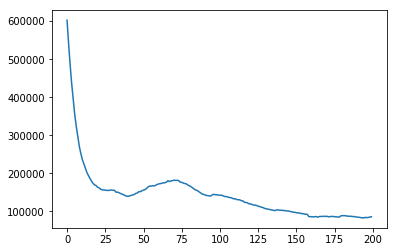

In [16]:
inference(predicted_mask, latent_dict, labels, session_dir='checkpoints/edward_test',restore_sess=False)

# Results

In [17]:
def criticism(predicted_mask,latent_dict):
    predicted_mask_post2 = ed.copy(predicted_mask, latent_dict)
    sess=ed.get_session()
    num_samples = 500
#     pred = predicted_mask_post2.eval(feed_dict={inputs:X_val,is_training:True})
#     pred = sess.run(predicted_mask_post2, feed_dict={inputs:X_val,is_training:True})
    acc = [accuracy_score(Y_val,sess.run(predicted_mask_post2, feed_dict={inputs:X_val,is_training:True})) 
             for _ in range(num_samples)] 
    prec = [precision_score(Y_val,sess.run(predicted_mask_post2, feed_dict={inputs:X_val,is_training:True})) 
             for _ in range(num_samples)]
    rec = [recall_score(Y_val,sess.run(predicted_mask_post2, feed_dict={inputs:X_val,is_training:True})) 
             for _ in range(num_samples)]

    roc = [roc_auc_score(Y_val,sess.run(predicted_mask_post2, feed_dict={inputs:X_val,is_training:True})) 
             for _ in range(num_samples)]
    f1 = [f1_score(Y_val,sess.run(predicted_mask_post2, feed_dict={inputs:X_val,is_training:True})) 
             for _ in range(num_samples)]

    return(np.array(acc),
           np.array(prec),
           np.array(rec),
           np.array(roc),
           np.array(f1))
acc,prec,rec,roc,f1 = criticism(predicted_mask,latent_dict)

In [18]:
def criticism2(predicted_mask, latent_dict, data_iterator, num_samples, ppc_nsamples=500):
    predicted_mask_post = ed.copy(predicted_mask, latent_dict)
    predicted_mask_post_samples = predicted_mask_post.sample(ppc_nsamples)
    sess = ed.get_session()
    sess.run(data_iterator.initializer)
    num_batches = num_samples // VAL_BATCH_SIZE
    for i in range(num_batches):
        data, labels = sess.run(data_iterator.get_next())
        labels = labels.flatten()
        ppc=sess.run(predicted_mask_post_samples,
                 feed_dict={inputs: data, predicted_mask: labels, is_training: True})
    return (ppc)
ppc = criticism2(predicted_mask,latent_dict,val_iterator,len(X_val))

(array([   4.,   10.,   33.,   76.,  111.,  108.,   87.,   55.,   12.,    4.]),
 array([ 0.67338129,  0.68359712,  0.69381295,  0.70402878,  0.7142446 ,
         0.72446043,  0.73467626,  0.74489209,  0.75510791,  0.76532374,
         0.77553957]),
 <a list of 10 Patch objects>)

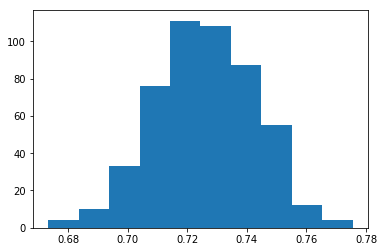

In [64]:
acc_list = []
for i in range(len(ppc)):
    acc_list.append(accuracy_score(Y_val,ppc[i]))
plt.hist(np.array(acc_list))

(array([   2.,    2.,   35.,   80.,  108.,  142.,   78.,   36.,   15.,    2.]),
 array([ 0.63021583,  0.64201439,  0.65381295,  0.66561151,  0.67741007,
         0.68920863,  0.70100719,  0.71280576,  0.72460432,  0.73640288,
         0.74820144]),
 <a list of 10 Patch objects>)

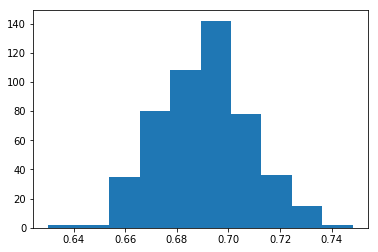

In [19]:
plt.hist(acc)

(array([ 184.,    0.,    0.,  215.,    0.,    0.,   94.,    0.,    0.,    7.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

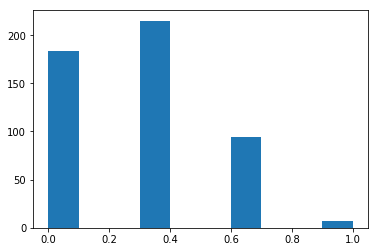

In [21]:
plt.hist(rec)

(array([ 145.,    0.,   28.,  200.,    0.,   23.,   81.,    8.,    3.,   12.]),
 array([ 0.        ,  0.00288462,  0.00576923,  0.00865385,  0.01153846,
         0.01442308,  0.01730769,  0.02019231,  0.02307692,  0.02596154,
         0.02884615]),
 <a list of 10 Patch objects>)

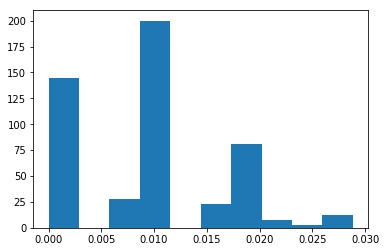

In [20]:
plt.hist(f1)

(array([ 161.,    0.,    0.,  216.,    1.,    0.,  108.,    1.,    0.,   13.]),
 array([ 0.31936416,  0.37348266,  0.42760116,  0.48171965,  0.53583815,
         0.58995665,  0.64407514,  0.69819364,  0.75231214,  0.80643064,
         0.86054913]),
 <a list of 10 Patch objects>)

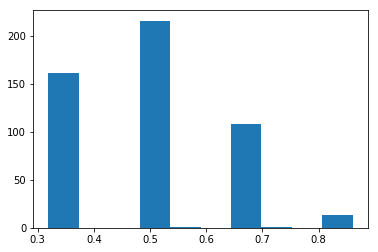

In [22]:
plt.hist(roc)

## No Edward

In [48]:

X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
D = X_train.shape[1]
Y_val = Y_val
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_train = Y_train.astype(np.int32)
Y_val = Y_val.astype(np.int32)
features = {'x':X_train}
drop_rate = .55


Y_train = Y_train.flatten()
Y_val = Y_val.flatten()
Y_test = np.array(Y_test).flatten()
nh1 = 512.0
nh2 = 256.0
nh3 = 128.0

In [42]:
Y_train.shape

(5482, 1)

In [49]:
def tf_model(features,labels,mode):       
        if tf.estimator.ModeKeys.TRAIN == 'train':
            is_training=True
        else:
            is_training = False
    
    
        layer1 =  tf.layers.conv1d(inputs=features['x'],name='x',filters=512,kernel_size=5,padding='same',
                                                       activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer1 =  tf.contrib.layers.batch_norm(layer1, is_training=is_training, decay=0.999)
        layer1 = tf.layers.dropout(inputs=layer1,training=is_training,rate=drop_rate)

        layer1 =  tf.layers.conv1d(inputs=layer1,filters=512,kernel_size=5,padding='same',
                                                       activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer1 =  tf.contrib.layers.batch_norm(layer1, is_training=is_training, decay=0.999)
        layer1 = tf.layers.dropout(inputs=layer1,training=is_training,rate=.55)

        
        layer2 =  tf.layers.conv1d(layer1,filters=256,kernel_size=5,padding='same',
                                   activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer2 =  tf.contrib.layers.batch_norm(layer2, is_training=is_training, decay=0.999)
        layer2 = tf.layers.dropout(inputs=layer2,training=is_training,rate=.55)


        layer3 =  tf.layers.conv1d(layer2,filters=128,kernel_size=5,padding='same',activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer3 =  tf.contrib.layers.batch_norm(layer3, is_training=is_training, decay=0.999)
        layer3 = tf.layers.dropout(inputs=layer1,training=is_training,rate=.55)


        layer4 =  tf.layers.conv1d(layer3,filters=128,kernel_size=3,padding='same',activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer4 =  tf.contrib.layers.batch_norm(layer4, is_training=is_training, decay=0.999)
        layer4 = tf.layers.dropout(inputs=layer4,training=is_training,rate=.35)


        layer5 =  tf.layers.conv1d(layer4,filters=128,kernel_size=3,padding='same',activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer5 =  tf.contrib.layers.batch_norm(layer5, is_training=is_training, decay=0.999)
        layer5 = tf.layers.dropout(inputs=layer5,training=is_training,rate=.35)


        layer6 =  tf.layers.conv1d(layer5,filters=128,kernel_size=3,padding='same',activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer6 =  tf.contrib.layers.batch_norm(layer6, is_training=is_training, decay=0.999)
        layer6 = tf.layers.dropout(inputs=layer6,training=is_training,rate=.35)

        layer6 =  tf.layers.conv1d(layer6,filters=128,kernel_size=3,padding='same',activation=tf.nn.relu,kernel_initializer=k.initializers.he_normal())
        layer6 =  tf.contrib.layers.batch_norm(layer6, is_training=is_training, decay=0.999)
        layer6 = tf.layers.dropout(inputs=layer6,training=is_training,rate=.35)

        flatten = tf.contrib.layers.flatten(inputs=layer6)
        
#         layer7 = tf.layers.dense(flatten,1024)
#         layer7 =  max_out(layer7,1024)
#         layer7 = tf.layers.dense(layer7,1024,activation=tf.nn.relu)
#         layer7 =  tf.contrib.layers.batch_norm(layer7, is_training=is_training, decay=0.999)
    #     layer7 = tf.layers.dropout(inputs=layer7,training=is_training,rate=drop_rate)

        layer8 = keras.layers.MaxoutDense(1024)(flatten)
        layer8 =  tf.contrib.layers.batch_norm(layer8, is_training=is_training, decay=0.999)
        
        layer9 = keras.layers.MaxoutDense(512)(layer8)
        layer9 =  tf.contrib.layers.batch_norm(layer9, is_training=is_training, decay=0.999)
        
        layer10 = keras.layers.MaxoutDense(256)(layer9)
        layer10 =  tf.contrib.layers.batch_norm(layer10, is_training=is_training, decay=0.999)


        logits = tf.layers.dense(layer10,units=2)
        

        predictions = {
          "classes": tf.argmax(input=logits, axis=1),
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
            }

        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

          # Calculate Loss (for both TRAIN and EVAL modes)
        ohc =  tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
        loss = tf.losses.softmax_cross_entropy(onehot_labels=ohc, logits=logits)

        # Configure the Training Op (for TRAIN mode)
        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

        # Add evaluation metrics (for EVAL mode)
        eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

sess = tf.InteractiveSession()

my_classifier = tf.estimator.Estimator(
    model_fn=tf_model)
    
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x":X_train},
      y=np.array(Y_train).flatten(),
      num_epochs=None,
      shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_val},
    y=Y_val,
    num_epochs=1,
    shuffle=False)


my_classifier.train(input_fn=train_input_fn, steps=3000)
eval_results = my_classifier.evaluate(input_fn=eval_input_fn)

predictions = list(my_classifier.predict(input_fn=eval_input_fn))
predicted_classes = [p["classes"] for p in predictions]
print(predicted_classes)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_tf_random_seed': 1, '_session_config': None, '_save_checkpoints_secs': 600, '_model_dir': '/tmp/tmplql71yjf', '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5}


/home/ubuntu/.local/lib/python3.5/site-packages/keras/legacy/layers.py:527: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmplql71yjf/model.ckpt.
INFO:tensorflow:loss = 0.988244, step = 1
INFO:tensorflow:global_step/sec: 23.8612
INFO:tensorflow:loss = 0.655306, step = 101 (4.192 sec)
INFO:tensorflow:global_step/sec: 25.7908
INFO:tensorflow:loss = 0.293596, step = 201 (3.877 sec)
INFO:tensorflow:global_step/sec: 25.8254
INFO:tensorflow:loss = 0.179726, step = 301 (3.872 sec)
INFO:tensorflow:global_step/sec: 25.568
INFO:tensorflow:loss = 0.168775, step = 401 (3.911 sec)
INFO:tensorflow:global_step/sec: 25.7686
INFO:tensorflow:loss = 0.0636823, step = 501 (3.881 sec)
INFO:tensorflow:global_step/sec: 25.7114
INFO:tensorflow:loss = 0.14321, step = 601 (3.889 sec)
INFO:tensorflow:global_step/sec: 25.7348
INFO:tensorflow:loss = 0.0108004, step = 701 (3.886 sec)
INFO:tensorflow:global_step/sec: 25.578
INFO:tensorflow:loss = 0.0110254, step = 801 (3.909 sec)
INFO:tensorflow:global_step/sec: 25.5185
INFO:tensorflow:loss =

In [50]:


acc = accuracy_score(Y_val,predicted_classes)
f1 = f1_score(Y_val,predicted_classes)
roc = roc_auc_score(Y_val,predicted_classes)
prec = precision_score(Y_val,predicted_classes)
recall= recall_score(Y_val,predicted_classes)


print (' Standard Deviations: {}'.format(number_stdev))
print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall))



 Standard Deviations: 3.5
 Accuracy: 0.8244604316546763
 F1: 0.03174603174603175
 RoC: 0.7459055876685934
 Precision: 0.016260162601626018
 Recall: 0.6666666666666666
